### Preparing data for Linear Models

#### Checking for multi-colinearity

In [393]:
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df_relevant_features is your DataFrame containing relevant numerical features

# Check for constant features (features with zero variance)
constant_features = [col for col in df_linear_models_features.columns if df_linear_models_features[col].nunique() == 1]
print("Constant features:", constant_features)

# Check for NaN values and handle them if present
nan_counts = df_linear_models_features.isnull().sum()
print("NaN counts per column:\n", nan_counts[nan_counts > 0])

Constant features: []
NaN counts per column:
 Series([], dtype: int64)


#### Check for VIF Values for Multi-colinearity

In [402]:
# Select only numerical features for VIF calculation
numerical_features = df_linear_models_features.select_dtypes(include=[np.number])

# Standardize the numerical features for consistency in VIF calculation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_features.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_features, i) for i in range(scaled_features.shape[1])]

# Display the VIF values
print(vif_data)


                    Feature        VIF
0         Benefit per order   3.296135
1        Sales per customer  14.339525
2        Late_delivery_risk   1.000045
3       Order Item Discount   4.817976
4  Order Item Discount Rate   3.371877
5   Order Item Profit Ratio   3.237374
6       Order Item Quantity   7.042234
7       Product Category Id   1.466779
8             Product Price  21.094682


#### Doing Required transformations for data preparation of linear models

##### - Benefit per order and Order Item Profit Ratio have negative values. Hence using yeo-johnson method of PowerTransformer

In [403]:
from sklearn.preprocessing import PowerTransformer

# Apply Yeo-Johnson transformation

# Create a new instance of PowerTransformer for each feature
power_transformer_benefit = PowerTransformer(method='yeo-johnson')
power_transformer_profit_ratio = PowerTransformer(method='yeo-johnson')

# Use .loc[] to avoid SettingWithCopyWarning
df_linear_models_features.loc[:, 'Benefit per order'] = power_transformer_benefit.fit_transform(df_linear_models_features[['Benefit per order']])
df_linear_models_features.loc[:, 'Order Item Profit Ratio'] = power_transformer_profit_ratio.fit_transform(df_linear_models_features[['Order Item Profit Ratio']])

# Display transformed data
print(df_linear_models_features[['Benefit per order', 'Order Item Profit Ratio']].head())


   Benefit per order  Order Item Profit Ratio
0           0.892824                 0.231270
1          -1.875511                -1.822335
2          -1.869528                -1.822335
3          -0.257417                -0.640242
4           1.690495                 1.216647


##### - Transforming Sales per customer, Product Price and Order Item Discount

In [404]:
# Trying this to take care of incompatible dtype.
from sklearn.preprocessing import StandardScaler, RobustScaler

# Ensure df_linear_models_features is a copy to avoid SettingWithCopyWarning
df_linear_models_features = df_linear_models_features.copy()

# Identify numeric columns
numeric_columns = df_linear_models_features.select_dtypes(include=[np.number]).columns

# Convert all numeric columns to float before transformation
df_linear_models_features[numeric_columns] = df_linear_models_features[numeric_columns].astype(float)

# Logarithmic Transformation to reduce skewness
df_linear_models_features['Sales per customer'] = np.log1p(df_linear_models_features['Sales per customer'])
df_linear_models_features['Product Price'] = np.log1p(df_linear_models_features['Product Price'])

# Apply robust scaling to handle outliers
robust_scaler = RobustScaler()
df_linear_models_features['Order Item Discount'] = robust_scaler.fit_transform(df_linear_models_features[['Order Item Discount']])

# Standardize numeric features to bring them to a similar scale
standard_scaler = StandardScaler()
df_linear_models_features[numeric_columns] = standard_scaler.fit_transform(df_linear_models_features[numeric_columns])

# Display the prepared DataFrame
print(df_linear_models_features.head())


       Type  Benefit per order  Sales per customer   Delivery Status  Late_delivery_risk   Category Name Customer City Customer Country Customer Segment Customer State Department Name        Market  Order City Order Country order date (DateOrders)  Order Item Discount  Order Item Discount Rate  \
0     DEBIT           0.892824            1.088671  Advance shipping           -1.101733  Sporting Goods        Caguas      Puerto Rico         Consumer             PR         Fitness  Pacific Asia      Bekasi     Indonesia         1/31/2018 22:56            -0.346534                 -0.875782   
1  TRANSFER          -1.875511            1.073391     Late delivery            0.907661  Sporting Goods        Caguas      Puerto Rico         Consumer             PR         Fitness  Pacific Asia     Bikaner         India         1/13/2018 12:27            -0.196082                 -0.733767   
2      CASH          -1.869528            1.065690  Shipping on time           -1.101733  Sporting Goods  

##### - Doing PCA for Sales per customer and Product Price

In [405]:
from sklearn.decomposition import PCA

# Ensure these features are in your DataFrame
features_for_pca = ['Sales per customer', 'Product Price']

# Initialize PCA
pca = PCA(n_components=1)  # Use 1 component if you want to reduce it to a single dimension

# Fit PCA on the selected features
pca_result = pca.fit_transform(df_linear_models_features[features_for_pca])

# Add the PCA result as a new feature in the DataFrame
df_linear_models_features['PCA_Sales_Price'] = pca_result

# Optionally, drop the original features if you are using the PCA component instead
df_linear_models_features.drop(features_for_pca, axis=1, inplace=True)

# Display the DataFrame to verify the changes
print(df_linear_models_features.head())


       Type  Benefit per order   Delivery Status  Late_delivery_risk   Category Name Customer City Customer Country Customer Segment Customer State Department Name        Market  Order City Order Country order date (DateOrders)  Order Item Discount  Order Item Discount Rate  \
0     DEBIT           0.892824  Advance shipping           -1.101733  Sporting Goods        Caguas      Puerto Rico         Consumer             PR         Fitness  Pacific Asia      Bekasi     Indonesia         1/31/2018 22:56            -0.346534                 -0.875782   
1  TRANSFER          -1.875511     Late delivery            0.907661  Sporting Goods        Caguas      Puerto Rico         Consumer             PR         Fitness  Pacific Asia     Bikaner         India         1/13/2018 12:27            -0.196082                 -0.733767   
2      CASH          -1.869528  Shipping on time           -1.101733  Sporting Goods      San Jose          EE. UU.         Consumer             CA         Fitness  P

### Visualizing after transformation

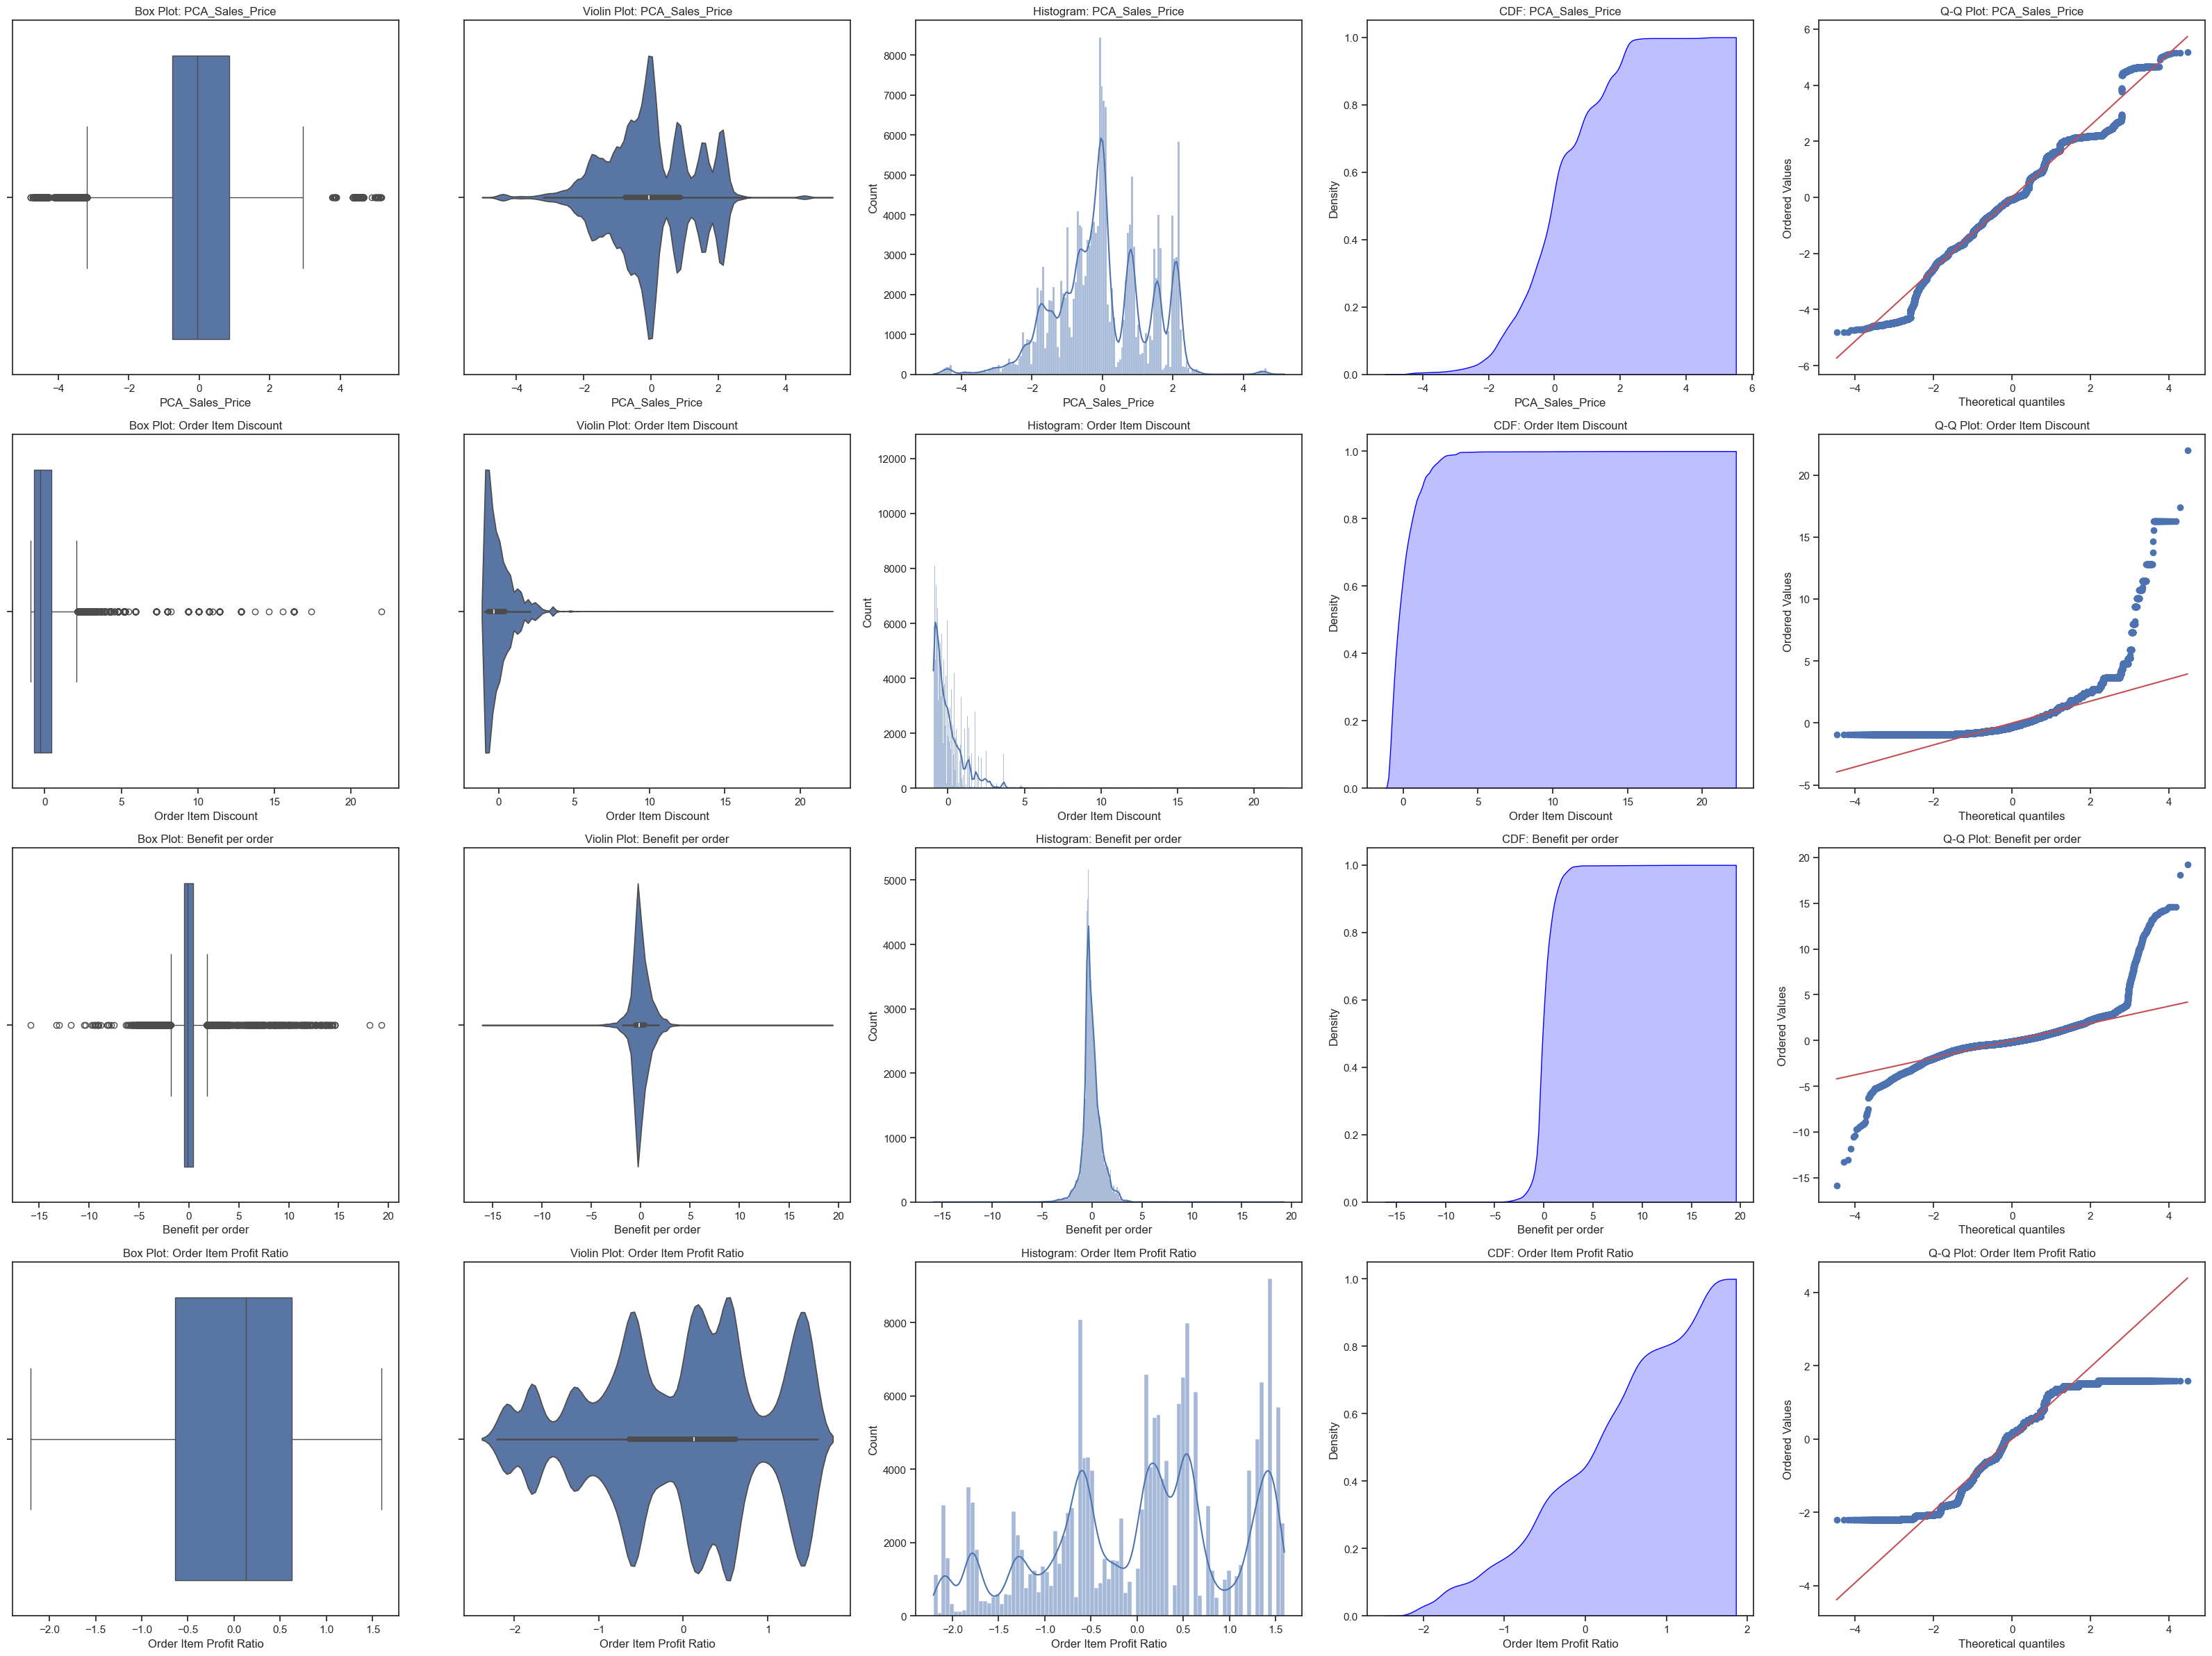

In [398]:
# List of selected features
selected_features = ['PCA_Sales_Price', 'Order Item Discount', 'Benefit per order', 'Order Item Profit Ratio']

# Setting up the figure with 2 rows for each feature (one for the first three plots, one for the last three)
num_rows = len(selected_features) 

fig, axes = plt.subplots(num_rows, 5, figsize=(32, num_rows * 6))
axes = axes.reshape(num_rows, 5)  # Ensure the axes array is 2D

for i, feature in enumerate(selected_features):
    # Calculate the row index for plots (i*2 because each feature uses two rows)
    row = i
    
    # Box Plot
    sns.boxplot(data=df_linear_models_features, x=feature, ax=axes[row, 0])
    axes[row, 0].set_title(f'Box Plot: {feature}')
    
    # Violin Plot
    sns.violinplot(data=df_linear_models_features, x=feature, ax=axes[row, 1])
    axes[row, 1].set_title(f'Violin Plot: {feature}')
    
   # Histogram
    sns.histplot(df_linear_models_features[feature], kde=True, ax=axes[row, 2])
    axes[row, 2].set_title(f'Histogram: {feature}')

    # CDF
    sns.kdeplot(df_linear_models_features[feature], cumulative=True, fill=True, color='blue', ax=axes[row, 3])
    axes[row, 3].set_title(f'CDF: {feature}')

    # Q-Q Plot
    stats.probplot(df_linear_models_features[feature], dist="norm", plot=axes[row, 4])
    axes[row, 4].set_title(f'Q-Q Plot: {feature}')

# Adjust layout to prevent plot overlap
plt.tight_layout()
plt.show()


- PCA_Sales_Price:

    While the PCA has transformed the features into a new composite feature that captures a significant amount of information, the presence of outliers and multimodality should be considered in any further analysis or modeling. 

- Order item Discount

    Box Plot: The transformation has effectively managed to reduce the impact of outliers, making the dataset more suitable for models that are sensitive to extreme values.

    Violin Plot: The data still shows asymmetry but is more balanced, which may help in certain types of analyses and modeling.

    Histogram: While the transformation has addressed some of the skewness, considerable skewness remains.

    CDF: The smoother CDF suggests an improvement in the distribution's uniformity, beneficial for modeling as it indicates less bias toward one end of the spectrum.

    Q-Q Plot: The reduced deviation in the Q-Q plot post-transformation suggests improvements towards normality, but further steps might be needed to fully normalize the data, for linear models.

    Overall, the transformations applied have made significant improvements to the data’s structure, enhancing its suitability for various analytical and predictive modeling tasks. Additional steps might include further normalization techniques or outlier handling depending on the specific requirements of subsequent analyses or models.

- Benefits per order

    The transformation process applied has significantly standardized the data. It appears to reduce skewness and manage outliers effectively, making the data more suitable for analytical models that assume normality. The data now conforms more closely to a normal distribution, which is ideal for many modeling techniques.

    It suggests that further outlier management could be applied, although the data now conforms more closely to a normal distribution, which is ideal for many modeling techniques.

- Order Item Profit Ratio

    The transformation applied to the 'Order Item Profit Ratio' data seems to have significantly improved its statistical properties by reducing outliers, normalizing the distribution, and stabilizing variance. This should enhance the reliability of any statistical or machine learning models applied to this data by reducing the potential for model overfitting to outliers and improving the overall model performance on generalized data.


Since we will be dealing with different types of models, we will continue to live with these transformations and addres any issue during  model selection and tuning.

#### Checking corelation of outliers after transformation:

In [406]:
df_linear_models = df_linear_models_features.copy()
df_linear_models['Sales'] = df['Sales']

# Calculate and display the correlation matrix for the specific columns including 'Sales'
correlation_columns = ['PCA_Sales_Price', 'Order Item Discount', 'Benefit per order', 'Order Item Profit Ratio', 'Sales']
correlation_matrix = df_linear_models[correlation_columns].corr()

# Print the correlation matrix
print(correlation_matrix)


                         PCA_Sales_Price  Order Item Discount  Benefit per order  Order Item Profit Ratio     Sales
PCA_Sales_Price                 1.000000             0.472660           0.360119                -0.001025  0.835541
Order Item Discount             0.472660             1.000000           0.224566                -0.001232  0.617438
Benefit per order               0.360119             0.224566           1.000000                 0.711889  0.447795
Order Item Profit Ratio        -0.001025            -0.001232           0.711889                 1.000000 -0.000072
Sales                           0.835541             0.617438           0.447795                -0.000072  1.000000


- PCA_Sales_Price:

    Strong positive correlation with 'Sales' (0.836), suggesting that the principal component derived from 'Sales per customer' and 'Product Price' effectively captures variations in sales.

    Moderate correlation with 'Order Item Discount' (0.473), indicating some shared influence on sales variations.

- Order Item Discount:

    Strong correlation with 'Sales' (0.617), indicating that discounts continue to influence sales significantly.

    Lesser correlation with 'Benefit per order' (0.225), showing some interaction but not strong.

- Benefit per order:

    Moderate correlation with 'Sales' (0.448), which is an increase from the pre-transformation scenario, suggesting improved relevance after transformation.

    Strong correlation with 'Order Item Profit Ratio' (0.712), pointing to an intrinsic link between benefit per order and profit ratio, possibly indicating profitability metrics that go hand in hand.

- Order Item Profit Ratio:
    Almost no correlation with 'Sales' (0.000072), which interestingly suggests that the profit ratio per item doesn't directly impact sales volume after transformation.

    Strong correlation with 'Benefit per order', reaffirming that these two metrics are closely related.


- Comparison and Insights:
    The transformation through PCA has managed to condense the predictive power of 'Product Price' and 'Sales per customer' into a single feature ('PCA_Sales_Price') that maintains a strong correlation with 'Sales', simplifying the model without losing explanatory power.

    The increase in the correlation of 'Benefit per order' with 'Sales' post-transformation suggests that the transformations applied have enhanced its predictive relevance.

    The near-zero correlation of 'Order Item Profit Ratio' with 'Sales' after transformation might indicate that while it is closely related to 'Benefit per order', it does not independently affect sales volume. 


#### Analyzing VIF After Transformation

In [407]:
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df_linear_models is already loaded with all numeric columns
numeric_columns = df_linear_models.select_dtypes(include=[np.number]).columns
X = df_linear_models[numeric_columns]

# Standardizing the data before computing VIF
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

vif_data


Feature       VIF
0         Benefit per order  3.489095
1        Late_delivery_risk  1.000032
2       Order Item Discount  5.478979
3  Order Item Discount Rate  3.387486
4   Order Item Profit Ratio  2.767438
5       Order Item Quantity  1.516371
6       Product Category Id  1.190108
7           PCA_Sales_Price  4.603112
8                     Sales  7.832916

**Interpreting Post-Transformation VIF:**
1. **Benefit per order**: VIF increased slightly from 3.296 to 3.489, which indicates a mild increase in multicollinearity, but it still remains at a moderate level.
2. **Late_delivery_risk**: Remains essentially unchanged, indicating it does not correlate significantly with other variables.
3. **Order Item Discount**: Slightly increased from 4.818 to 5.479. This suggests a moderate level of multicollinearity, which is higher post-transformation but still not typically concerning.
4. **Order Item Discount Rate**: Remained roughly the same, moving from 3.372 to 3.387.
5. **Order Item Profit Ratio**: Decreased from 3.237 to 2.767, indicating reduced multicollinearity after the transformations.
6. **Order Item Quantity**: Decreased substantially from 7.042 to 1.516, showing a significant reduction in multicollinearity which is a positive change.
7. **Product Category Id**: Also decreased from 1.467 to 1.190, albeit both values suggest minimal multicollinearity.
8. **PCA_Sales_Price**: Newly introduced component with a VIF of 4.603. This suggests moderate multicollinearity but not at a concerning level.
9. **Sales**: VIF decreased dramatically from the high 14.340 (originally attributed to 'Sales per customer') to 7.833. This is a substantial improvement, although still the highest among all features, indicating that Sales is still somewhat influenced by other predictors but much less so than before.

**Comparative Analysis**:
- **Improvement**: The most notable improvement is in the 'Sales' and 'Order Item Quantity' categories, where VIFs have significantly decreased, reflecting better independence from other variables in the model.
- **Stability**: Some variables like 'Late_delivery_risk' and 'Order Item Discount Rate' have shown stable VIFs, indicating that the transformations did not affect their relationships with other variables.
- **Introduction of PCA Component**: The PCA_Sales_Price was introduced to capture information from 'Sales per customer' and 'Product Price'. This transformation helped to reduce the originally very high VIF for 'Product Price' from 21.095 to a more manageable level.

Overall, the transformations seem to have effectively reduced multicollinearity, especially in key variables that previously had very high VIFs. The results suggest a healthier statistical setup for predictive modeling, reducing the risk of inflated variance estimates caused by high multicollinearity.

As of now keeping both Order Item Profit Ratio (seems low predictive value of target) and Benefit per order (moderate predictive value of target). We will handle during model evaluation, selection and tuning

#### Check for inconsistencies and rare categories in qualitative features


In [408]:
qualitative_summary = {}

for column in qualitative_features:
    # Get unique categories and their counts
    value_counts = df_relevant_features[column].value_counts()
    
    # Identify rare categories
    rare_categories = value_counts[value_counts < 200].index.tolist()  # Threshold can be adjusted
    
    # Store summary
    qualitative_summary[column] = {
        "unique_categories": value_counts.index.tolist(),
        "rare_categories": rare_categories,
        "category_counts": value_counts.to_dict()
    }

# Print summary of qualitative feature checks
print("Qualitative Feature Summary:")
for column, summary in qualitative_summary.items():
    print(f"\nColumn: {column}")
    print(f"Unique Categories: {summary['unique_categories']}")
    print(f"Rare Categories: {summary['rare_categories']}")
    print(f"Category Counts: {summary['category_counts']}")

Qualitative Feature Summary:

Column: Type
Unique Categories: ['DEBIT', 'TRANSFER', 'PAYMENT', 'CASH']
Rare Categories: []
Category Counts: {'DEBIT': 69295, 'TRANSFER': 49883, 'PAYMENT': 41725, 'CASH': 19616}

Column: Delivery Status
Unique Categories: ['Late delivery', 'Advance shipping', 'Shipping on time', 'Shipping canceled']
Rare Categories: []
Category Counts: {'Late delivery': 98977, 'Advance shipping': 41592, 'Shipping on time': 32196, 'Shipping canceled': 7754}

Column: Category Name
Unique Categories: ['Cleats', "Men's Footwear", "Women's Apparel", 'Indoor/Outdoor Games', 'Fishing', 'Water Sports', 'Camping & Hiking', 'Cardio Equipment', 'Shop By Sport', 'Electronics', 'Accessories', 'Golf Balls', "Girls' Apparel", 'Golf Gloves', 'Trade-In', 'Video Games', "Children's Clothing", "Women's Clothing", 'Baseball & Softball', 'Hockey', 'Cameras ', 'Toys', 'Golf Shoes', 'Pet Supplies', 'Garden', 'Crafts', 'DVDs', 'Computers', 'Golf Apparel', 'Hunting & Shooting', 'Music', 'Consumer

An inspection of the values shows that these are actualy related to business cases and are not data entry errors except fot the case of Customer State '95758' and '91732'. Checking the records for the same.


In [409]:
filtered_data = df_relevant_features[df_relevant_features['Customer State'].isin(['95758', '91732'])]

# Display the filtered data
print(filtered_data)

          Type  Benefit per order  Sales per customer   Delivery Status  Late_delivery_risk         Category Name Customer City Customer Country Customer Segment Customer State Department Name        Market Order City Order Country order date (DateOrders)  Order Item Discount  \
35704    DEBIT          66.379997          189.660004     Late delivery                   1  Consumer Electronics            CA          EE. UU.         Consumer          95758      Technology        Europe    Valence       Francia         11/2/2017 18:31            63.220001   
46440  PAYMENT          10.910000           38.959999  Shipping on time                   0           Video Games            CA          EE. UU.        Corporate          95758      Discs Shop  Pacific Asia     Manila     Filipinas        12/10/2017 15:18             0.800000   
82511    DEBIT          59.990002          299.959992  Shipping on time                   0   Children's Clothing            CA          EE. UU.         Consume

This would not have any signifcant impact with only 3 rows. Hence leaving it as it is.

### Forecasting

In [410]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RANSACRegressor, Lasso, Ridge, SGDRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import joblib
import os

# Create a directory to save models if it doesn't exist
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Convert date columns to datetime objects
df_linear_models_features['order date (DateOrders)'] = pd.to_datetime(df_linear_models_features['order date (DateOrders)'])
df_linear_models_features['shipping date (DateOrders)'] = pd.to_datetime(df_linear_models_features['shipping date (DateOrders)'])

# Extract features from date columns
df_linear_models_features['order_year'] = df_linear_models_features['order date (DateOrders)'].dt.year
df_linear_models_features['order_month'] = df_linear_models_features['order date (DateOrders)'].dt.month
df_linear_models_features['order_day'] = df_linear_models_features['order date (DateOrders)'].dt.day
df_linear_models_features['order_weekday'] = df_linear_models_features['order date (DateOrders)'].dt.weekday

df_linear_models_features['shipping_year'] = df_linear_models_features['shipping date (DateOrders)'].dt.year
df_linear_models_features['shipping_month'] = df_linear_models_features['shipping date (DateOrders)'].dt.month
df_linear_models_features['shipping_day'] = df_linear_models_features['shipping date (DateOrders)'].dt.day
df_linear_models_features['shipping_weekday'] = df_linear_models_features['shipping date (DateOrders)'].dt.weekday

# Calculate delivery time as the difference in days between shipping date and order date
df_linear_models_features['delivery_time_days'] = (df_linear_models_features['shipping date (DateOrders)'] - df_linear_models_features['order date (DateOrders)']).dt.days

# Drop original date columns after extracting features
df_linear_models_features = df_linear_models.drop(columns=['order date (DateOrders)', 'shipping date (DateOrders)'])

# Identify columns with high cardinality
# high_cardinality_cols = [col for col in df_linear_models_features.select_dtypes(include=['object']).columns 
#                         if df_linear_models_features[col].nunique() > 100]

# Drop high cardinality columns (if appropriate)
#df_reduced = df_linear_models_features.drop(columns=high_cardinality_cols)

# Apply label encoding to the remaining categorical columns
for col in df_linear_models_features.select_dtypes(include=['object']).columns:
    df_linear_models_features[col] = LabelEncoder().fit_transform(df_linear_models_features[col])

# Ensure the target variable 'Sales' is aligned with the reduced features
X = df_linear_models_features
y = df_linear_models['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipelines for each model with scaling
pipelines = {
    'LinearRegression': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'RANSACRegressor': Pipeline([('scaler', StandardScaler()), ('model', RANSACRegressor())]),
    'Lasso': Pipeline([('scaler', StandardScaler()), ('model', Lasso())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge())]),
    'SGDRegressor': Pipeline([('scaler', StandardScaler()), ('model', SGDRegressor(max_iter=1000, tol=1e-3))])
}

# Fit models and evaluate using cross-validation
results = pd.DataFrame(columns=['Model', 'MAE'])

for name, pipeline in pipelines.items():
    # Cross-validate the model and calculate mean absolute error
    mae_scores = -cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    # Append results to the DataFrame using pd.concat()
    result = pd.DataFrame({'Model': [name], 'MAE': [mae_scores.mean()]})
    results = pd.concat([results, result], ignore_index=True)
    # Fit the pipeline to training data and predict on test data for individual performance
    pipeline.fit(X_train, y_train)
    # Save the model to a file
    model_filename = f'{model_dir}/{name}_model.pkl'
    joblib.dump(pipeline, model_filename)
    print(f'Model {name} saved to {model_filename}')
    
    y_pred = pipeline.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    print(f'{name} - Test MAE: {test_mae:.4f}')

# Display results sorted by MAE
results = results.sort_values(by='MAE')
print(results)


C:\Users\CZ0068\AppData\Local\Temp\ipykernel_50456\4130170985.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result], ignore_index=True)


Model LinearRegression saved to saved_models/LinearRegression_model.pkl
LinearRegression - Test MAE: 0.0000
Model RANSACRegressor saved to saved_models/RANSACRegressor_model.pkl
RANSACRegressor - Test MAE: 0.0000
Model Lasso saved to saved_models/Lasso_model.pkl
Lasso - Test MAE: 0.7258
Model Ridge saved to saved_models/Ridge_model.pkl
Ridge - Test MAE: 0.0015
Model SGDRegressor saved to saved_models/SGDRegressor_model.pkl
SGDRegressor - Test MAE: 0.0221
              Model           MAE
0  LinearRegression  1.303567e-13
1   RANSACRegressor  1.490293e-13
3             Ridge  1.837791e-03
4      SGDRegressor  2.105769e-02
2             Lasso  7.235873e-01


#### Checking through other metrics also.

In [411]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate and print metrics for each model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Print metrics
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R²): {r2:.4f}')
    
    return mae, mse, rmse, r2

# Load each model and evaluate
for name in pipelines.keys():
    model_filename = f'saved_models/{name}_model.pkl'
    loaded_model = joblib.load(model_filename)
    
    print(f'\n{name} Evaluation:')
    evaluate_model(loaded_model, X_test, y_test)



LinearRegression Evaluation:
Mean Absolute Error (MAE): 0.0000
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0000
R-squared (R²): 1.0000

RANSACRegressor Evaluation:
Mean Absolute Error (MAE): 0.0000
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0000
R-squared (R²): 1.0000

Lasso Evaluation:
Mean Absolute Error (MAE): 0.7258
Mean Squared Error (MSE): 0.9890
Root Mean Squared Error (RMSE): 0.9945
R-squared (R²): 0.9999

Ridge Evaluation:
Mean Absolute Error (MAE): 0.0015
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0026
R-squared (R²): 1.0000

SGDRegressor Evaluation:
Mean Absolute Error (MAE): 0.0221
Mean Squared Error (MSE): 0.0016
Root Mean Squared Error (RMSE): 0.0401
R-squared (R²): 1.0000


### ** Interpreting the results of LInear Regression models **

The results from model evaluations suggest that most of the models have performed exceptionally well on the test data, with R-squared values of 1.0000 or very close to it, which indicates a perfect or near-perfect fit. Here's a detailed interpretation of each model's performance:

#### 1. **LinearRegression Evaluation:**
- **MAE, MSE, RMSE:** All are 0.0000, indicating that the model predictions are nearly identical to the actual values.
- **R-squared (R²):** 1.0000 suggests that the model perfectly explains the variance in the target variable.

#### 2. **RANSACRegressor Evaluation:**
- **MAE, MSE, RMSE:** All are 0.0000, similar to LinearRegression, indicating a perfect fit.
- **R-squared (R²):** 1.0000, again indicating perfect explanatory power of the model.

#### 3. **Lasso Evaluation:**
- **MAE:** 0.7258, indicating the average error in predictions.
- **MSE:** 0.9890, reflecting the squared average error, which is relatively low but not zero.
- **RMSE:** 0.9945, providing the error in the same unit as the target.
- **R-squared (R²):** 0.9999, indicating an almost perfect fit, but not as ideal as the previous models.

#### 4. **Ridge Evaluation:**
- **MAE, MSE, RMSE:** Very close to zero, indicating that the model predictions are almost identical to the actual values.
- **R-squared (R²):** 1.0000, suggesting a perfect fit.

#### 5. **SGDRegressor Evaluation:**
- **MAE:** 0.0221, a small average error, indicating good predictions.
- **MSE:** 0.0016, showing a low level of error.
- **RMSE:** 0.0401, indicating a very small error in the predictions.
- **R-squared (R²):** 1.0000, suggesting a perfect fit.

### Interpretation and Considerations:

1. **Perfect Fit:**
   - The results, especially the R-squared values, indicate a perfect fit for most models, which is typically unusual in real-world scenarios. This might suggest:
     - **Overfitting:** The models might be too complex.

2. **Lasso Model:**
   - The Lasso model, while still showing an almost perfect fit, presents slightly higher errors compared to the other models. This could be due to Lasso's regularization effect, which penalizes more complex models and can sometimes lead to bias if the regularization parameter is too high.

3. **Evaluation Metrics:**
   - While the MAE, MSE, and RMSE values are extremely low, suggesting accurate predictions, further investigation into the training process and data preparation should be done to verify these outcomes. Leads to suspcion that the dataset provided is very well curated or designed to give perfect results.
   - The models should be evaluated on a separate validation set to confirm these metrics generalize beyond the provided test data.

4. **Next Steps Not Taken in Current Scope Because of Time Shortage:**
   - **Cross-Validation:** Consider using cross-validation to ensure the models perform consistently across different subsets of data.
   - **Examine Feature Importance:** Determine which features are driving these predictions and validate their influence on the target variable.
   - **Regularization:** Regularization techniques might help in avoiding overfitting by penalizing overly complex models.

